In [ ]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 KB 4.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from category_encoders.ordinal import OrdinalEncoder
from category_encoders.one_hot import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, f1_score, roc_auc_score, confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score, ConfusionMatrixDisplay, recall_score, precision_score

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

In [ ]:
train_df = pd.read_csv('fraud_oracle.csv')
train_df.head()

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,...,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,...,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,...,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,...,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,...,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Month                 15420 non-null  object
 1   WeekOfMonth           15420 non-null  int64 
 2   DayOfWeek             15420 non-null  object
 3   Make                  15420 non-null  object
 4   AccidentArea          15420 non-null  object
 5   DayOfWeekClaimed      15420 non-null  object
 6   MonthClaimed          15420 non-null  object
 7   WeekOfMonthClaimed    15420 non-null  int64 
 8   Sex                   15420 non-null  object
 9   MaritalStatus         15420 non-null  object
 10  Age                   15420 non-null  int64 
 11  Fault                 15420 non-null  object
 12  PolicyType            15420 non-null  object
 13  VehicleCategory       15420 non-null  object
 14  VehiclePrice          15420 non-null  object
 15  FraudFound_P          15420 non-null

In [ ]:
#to find columns with null values
train_df.isnull().sum()

Month                   0
WeekOfMonth             0
DayOfWeek               0
Make                    0
AccidentArea            0
DayOfWeekClaimed        0
MonthClaimed            0
WeekOfMonthClaimed      0
Sex                     0
MaritalStatus           0
Age                     0
Fault                   0
PolicyType              0
VehicleCategory         0
VehiclePrice            0
FraudFound_P            0
PolicyNumber            0
RepNumber               0
Deductible              0
DriverRating            0
Days_Policy_Accident    0
Days_Policy_Claim       0
PastNumberOfClaims      0
AgeOfVehicle            0
AgeOfPolicyHolder       0
PoliceReportFiled       0
WitnessPresent          0
AgentType               0
NumberOfSuppliments     0
AddressChange_Claim     0
NumberOfCars            0
Year                    0
BasePolicy              0
dtype: int64

In [ ]:
#printing unique values in columns
for column in train_df:
    if column == 'PolicyNumber':
        pass
    else:
        print(column)
        print(sorted(train_df[column].unique()),"\n")

Month
['Apr', 'Aug', 'Dec', 'Feb', 'Jan', 'Jul', 'Jun', 'Mar', 'May', 'Nov', 'Oct', 'Sep'] 

WeekOfMonth
[1, 2, 3, 4, 5] 

DayOfWeek
['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday'] 

Make
['Accura', 'BMW', 'Chevrolet', 'Dodge', 'Ferrari', 'Ford', 'Honda', 'Jaguar', 'Lexus', 'Mazda', 'Mecedes', 'Mercury', 'Nisson', 'Pontiac', 'Porche', 'Saab', 'Saturn', 'Toyota', 'VW'] 

AccidentArea
['Rural', 'Urban'] 

DayOfWeekClaimed
['0', 'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday'] 

MonthClaimed
['0', 'Apr', 'Aug', 'Dec', 'Feb', 'Jan', 'Jul', 'Jun', 'Mar', 'May', 'Nov', 'Oct', 'Sep'] 

WeekOfMonthClaimed
[1, 2, 3, 4, 5] 

Sex
['Female', 'Male'] 

MaritalStatus
['Divorced', 'Married', 'Single', 'Widow'] 

Age
[0, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 7

In [ ]:
value_counts = train_df['FraudFound_P'].value_counts()
# Calculate the ratio of each value count to the total count
value_ratios = value_counts*100 / value_counts.sum()

# Print the resulting value ratios
print(value_ratios)

0    94.014267
1     5.985733
Name: FraudFound_P, dtype: float64


# Feature Engineering

In [ ]:
train_df['AccidentArea'] = train_df['AccidentArea'].replace({'Urban':1, 'Rural':0})

train_df['Sex'] =train_df['Sex'].replace({'Female':1, 'Male':0})

train_df['Fault'] = train_df['Fault'].replace({'Policy Holder':1, 'Third Party':0})

train_df['PoliceReportFiled'] = train_df['PoliceReportFiled'].replace({'Yes':1, 'No':0})

train_df['WitnessPresent'] = train_df['WitnessPresent'].replace({'Yes':1, 'No':0})

train_df['AgentType'] = train_df['AgentType'].replace({'External':1, 'Internal':0})

train_df['Month'] = train_df['Month'].replace({'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,'Jul':7,'Aug':8,'Sep':9,'Oct':10,'Nov':11,'Dec':12})

train_df['DayOfWeek'] = train_df['DayOfWeek'].replace({'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6,'Sunday':7})

train_df['MonthClaimed'] = train_df['MonthClaimed'].replace({'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,'Jul':7,'Aug':8,'Sep':9,'Oct':10,'Nov':11,'Dec':12})

train_df['DayOfWeekClaimed'] = train_df['DayOfWeekClaimed'].replace({'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6,'Sunday':7})

train_df['PastNumberOfClaims'] = train_df['PastNumberOfClaims'].replace({'none':0 ,'1':1,'2 to 4':2,'more than 4':3})

train_df['NumberOfSuppliments'] = train_df['NumberOfSuppliments'].replace({'none':0,'1 to 2':1,'3 to 5':2,'more than 5':4})

train_df['VehiclePrice'] = train_df['VehiclePrice'].replace({'less than 20000':0,'20000 to 29000':1,'30000 to 39000':2,
                                                  '40000 to 59000':3,'60000 to 69000':4,'more than 69000':5})
train_df['AgeOfVehicle'] = train_df['AgeOfVehicle'].replace({'3 years':3,'6 years':6,'7 years':7,'more than 7':8,'5 years':5,'new':0,'4 years':4,'2 years':2})

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Month                 15420 non-null  int64 
 1   WeekOfMonth           15420 non-null  int64 
 2   DayOfWeek             15420 non-null  int64 
 3   Make                  15420 non-null  object
 4   AccidentArea          15420 non-null  int64 
 5   DayOfWeekClaimed      15420 non-null  object
 6   MonthClaimed          15420 non-null  object
 7   WeekOfMonthClaimed    15420 non-null  int64 
 8   Sex                   15420 non-null  int64 
 9   MaritalStatus         15420 non-null  object
 10  Age                   15420 non-null  int64 
 11  Fault                 15420 non-null  int64 
 12  PolicyType            15420 non-null  object
 13  VehicleCategory       15420 non-null  object
 14  VehiclePrice          15420 non-null  int64 
 15  FraudFound_P          15420 non-null

In [ ]:
# select only the categorical columns
cat_cols = train_df.select_dtypes(include=['object']).columns.tolist()

# print the list of categorical columns
print(cat_cols)

['Make', 'DayOfWeekClaimed', 'MonthClaimed', 'MaritalStatus', 'PolicyType', 'VehicleCategory', 'Days_Policy_Accident', 'Days_Policy_Claim', 'AgeOfPolicyHolder', 'AddressChange_Claim', 'NumberOfCars', 'BasePolicy']


In [ ]:
col_ordering = [
    {'col':'AccidentArea','mapping':{'Urban':1, 'Rural':0}},
    {'col':'Sex','mapping':{'Female':1, 'Male':0}},
    {'col':'Fault','mapping':{'Policy Holder':1, 'Third Party':0}},
    {'col':'PoliceReportFiled','mapping':{'Yes':1, 'No':0}},
    {'col':'WitnessPresent','mapping':{'Yes':1, 'No':0}},
    {'col':'AgentType','mapping':{'External':1, 'Internal':0}},
    {'col':'Month','mapping':{'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,'Jul':7,'Aug':8,'Sep':9,'Oct':10,'Nov':11,'Dec':12}},
    {'col':'DayOfWeek','mapping':{'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6,'Sunday':7}},
    {'col':'DayOfWeekClaimed','mapping':{'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6,'Sunday':7}},
    {'col':'MonthClaimed','mapping':{'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,'Jul':7,'Aug':8,'Sep':9,'Oct':10,'Nov':11,'Dec':12}},
    {'col':'PastNumberOfClaims','mapping':{'none':0 ,'1':1,'2 to 4':2,'more than 4':3 }},
    {'col':'NumberOfSuppliments','mapping':{'none':0,'1 to 2':1,'3 to 5':2,'more than 5':3}}, 
    {'col':'VehiclePrice','mapping':{'less than 20000':0,'20000 to 29000':1,'30000 to 39000':2,
                                     '40000 to 59000':3,'60000 to 69000':4,'more than 69000':5}},
    {'col':'AgeOfVehicle','mapping':{'3 years':3,'6 years':6,'7 years':7,'more than 7':8,'5 years':5,'new':0,'4 years':4,'2 years':2}},
    {'col':'Days_Policy_Accident','mapping':{'more than 30':4,'15 to 30':3,'none':0,'1 to 7':1,'8 to 15':2}},
    {'col':'Days_Policy_Claim','mapping':{'more than 30':4,'15 to 30':3,'none':0,'1 to 7':1,'8 to 15':2}},
    {'col':'AgeOfPolicyHolder','mapping':{'16 to 17':1,'18 to 20':2,'21 to 25':3,'26 to 30':4,'31 to 35':5,'36 to 40':6,
                                          '41 to 50':7,'51 to 65':8,'over 65':9}},
    {'col':'AddressChange_Claim','mapping':{'no change':0,'under 6 months':1,'1 year':2,'2 to 3 years':3,'4 to 8 years':4}},
    {'col':'NumberOfCars','mapping':{'1 vehicle':1,'2 vehicles':2,'3 to 4':3,'5 to 8':4,'more than 8':5}}
]
ord_encoder = OrdinalEncoder(mapping = col_ordering, return_df=True)

In [ ]:
train_df2 = ord_encoder.fit_transform(train_df)

In [ ]:
OHE = OneHotEncoder(cols = ['Make','MaritalStatus','VehicleCategory','BasePolicy'],use_cat_names=True, return_df=True) 
train_df3 = OHE.fit_transform(train_df2)

In [ ]:
train_df3.head()

,Month,WeekOfMonth,DayOfWeek,Make_Honda,Make_Toyota,Make_Ford,Make_Mazda,Make_Chevrolet,Make_Pontiac,Make_Accura,...,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy_Liability,BasePolicy_Collision,BasePolicy_All Perils
0,12,5,3,1,0,0,0,0,0,0,...,0,0,1,0,2,3,1994,1,0,0
1,1,3,3,1,0,0,0,0,0,0,...,1,0,1,0,0,1,1994,0,1,0
2,10,5,5,1,0,0,0,0,0,0,...,0,0,1,0,0,1,1994,0,1,0
3,6,2,6,0,1,0,0,0,0,0,...,1,0,1,3,0,1,1994,1,0,0
4,1,5,1,1,0,0,0,0,0,0,...,0,0,1,0,0,1,1994,0,1,0


In [ ]:
# create dummy variables for the 'colors' column
dummies = pd.get_dummies(train_df3['PolicyType'])

# concatenate the dummies to the original dataframe
train_df3 = pd.concat([train_df3, dummies], axis=1)

# drop the original 'colors' column
train_df3.drop('PolicyType', axis=1, inplace=True)

In [ ]:
train_df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 66 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Month                    15420 non-null  int64  
 1   WeekOfMonth              15420 non-null  int64  
 2   DayOfWeek                15420 non-null  int64  
 3   Make_Honda               15420 non-null  int64  
 4   Make_Toyota              15420 non-null  int64  
 5   Make_Ford                15420 non-null  int64  
 6   Make_Mazda               15420 non-null  int64  
 7   Make_Chevrolet           15420 non-null  int64  
 8   Make_Pontiac             15420 non-null  int64  
 9   Make_Accura              15420 non-null  int64  
 10  Make_Dodge               15420 non-null  int64  
 11  Make_Mercury             15420 non-null  int64  
 12  Make_Jaguar              15420 non-null  int64  
 13  Make_Nisson              15420 non-null  int64  
 14  Make_VW               

In [ ]:
train_df3= train_df3.drop(columns='PolicyNumber')

In [ ]:
X = train_df3.drop(columns='FraudFound_P')
y = train_df3['FraudFound_P']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=48, stratify=y)

# Model Fitting and Comparison

In [ ]:

modelname, acc, recall, precision, f1, roc_auc = [],[],[],[],[],[]
model = {'xgboost':XGBClassifier(use_label_encoder=False, objective= 'binary:logistic',eval_metric='aucpr'), 
         'LightGBM':LGBMClassifier(is_unbalance=True),
          'adaboost':AdaBoostClassifier(), 
          'gradientb':GradientBoostingClassifier(),
}


def fit_model(x_train, x_test, y_train, y_test, sampling):
    for key,value in zip(model, model.values()):
        print(f"Model {key} {sampling}")
        ml_model = value
        ml_model.fit(x_train, y_train)
        y_pred = ml_model.predict(x_test)
        
        modelname.append(f'{key} {sampling}')
        acc.append(accuracy_score(y_test, y_pred))
        f1.append(f1_score(y_test, y_pred))
        recall.append(recall_score(y_test, y_pred))
        precision.append(precision_score(y_test, y_pred))
        roc_auc.append(roc_auc_score(y_test, y_pred))



def sampling(x_train, y_train, kind='over', ss=0.5):
    if kind == 'over':
        oversample = SMOTE(sampling_strategy=ss)
        X, y = oversample.fit_resample(x_train, y_train)
    elif kind == 'under':
        join_train = pd.concat([x_train, y_train], axis=1)
        claim = join_train[join_train['FraudFound_P']==1]
        no_claim = join_train[join_train['FraudFound_P']==0]

        undersample_noclaim = no_claim.sample(len(claim)*3)
        join_train2 = pd.concat([claim,undersample_noclaim]).sample(frac=1)

        X = join_train2.drop(columns='FraudFound_P')
        y = join_train2['FraudFound_P']
    return X, y


def metric_result(y_test, y_pred):
    print("F1 Score : ",f1_score(y_test, y_pred, average='binary'))
    print("Recall Score : ",recall_score(y_test, y_pred))
    print("Precision Score : ",precision_score(y_test, y_pred))

    ig, ax = plt.subplots(1,2, figsize=(10,5))
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax[0])
    ax[0].set_title('Confusion Matrix')

    # ROC AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    ax[1].plot(fpr,tpr, label="AUC="+str(auc))
    ax[1].set_title('ROC AUC')
    ax[1].set_ylabel('True Positive Rate')
    ax[1].set_xlabel('False Positive Rate')
    ax[1].legend(loc=4)
    plt.show()


def glm_result(res, X_test, y_test):
    X_test_sm = sm.add_constant(X_test)
    y_pred = res.predict(X_test_sm)

    df_res = pd.DataFrame({'is_claim_real':y_test, 'is_claim_prob':y_pred})
    numbers = [float(x)/10 for x in range(10)]
    for i in numbers:
        df_res[i]= df_res.is_claim_prob.map(lambda x: 1 if x > i else 0)
    cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])

    cut_off = [0.0,0.05, 0.1, 0.15 , 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]
    f1_result = []
    for i in cut_off:
        df_res['final_predicted'] = df_res['is_claim_prob'].map( lambda x: 1 if x > i else 0)
        f1_result.append(roc_auc_score(df_res['is_claim_real'], df_res['final_predicted']))
    df_res2 = pd.DataFrame({'cut_off':cut_off, 'f1_score':f1_result})
    best_tresh = df_res2.sort_values('f1_score', ascending=False).head(1)['cut_off'].values[0]
    y_pred_thresh = (y_pred >= best_tresh).astype('float')
    print('Best Threshold :', best_tresh)
    metric_result(y_test, y_pred_thresh)


def find_best_tresh(pred_proba, y_test):
    df_res = pd.DataFrame({'prob':pred_proba})
    cut_off = [0.0,0.05, 0.1, 0.15 , 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]
    f1_result = []
    for i in cut_off:
        df_res['final_predicted'] = df_res['prob'].map( lambda x: 1 if x > i else 0)
        f1_result.append(roc_auc_score(y_test, df_res['final_predicted']))
    df_res2 = pd.DataFrame({'cut_off':cut_off, 'f1_score':f1_result})
    best_tresh = df_res2.sort_values('f1_score', ascending=False).head(1)['cut_off'].values[0]
    y_pred_thresh = (y_pred >= best_tresh).astype('float')
    print('Best Threshold :', best_tresh)
    metric_result(y_test, y_pred_thresh)
     

/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [ ]:
#without sampling
fit_model(X_train, X_test, y_train, y_test, 'Normal')

Model xgboost Normal
Model LightGBM Normal
Model adaboost Normal
Model gradientb Normal


In [ ]:
oversample = SMOTE(sampling_strategy=0.5)
X_over, y_over = oversample.fit_resample(X_train, y_train)
fit_model(X_over, X_test, y_over, y_test, 'over')

Model xgboost over
Model LightGBM over
Model adaboost over
Model gradientb over


In [ ]:
join_train = pd.concat([X_train, y_train], axis=1)
claim = join_train[join_train['FraudFound_P']==1]
no_claim = join_train[join_train['FraudFound_P']==0]

undersample_noclaim = no_claim.sample(len(claim)*2)
join_train2 = pd.concat([claim,undersample_noclaim]).sample(frac=1)

X_under = join_train2.drop(columns='FraudFound_P')
y_under = join_train2['FraudFound_P']

fit_model(X_under, X_test, y_under, y_test, 'Under')

Model xgboost Under
Model LightGBM Under
Model adaboost Under
Model gradientb Under


In [ ]:
df_model = pd.DataFrame({'model':modelname, 'accuracy':acc, 'recall':recall, 'precision':precision, 'f1':f1, 'roc_auc':roc_auc})
df_model

,model,accuracy,recall,precision,f1,roc_auc
0,xgboost Normal,0.961414,0.481081,0.794643,0.599327,0.736574
1,LightGBM Normal,0.921530,0.859459,0.424000,0.567857,0.892476
2,adaboost Normal,0.936122,0.032432,0.250000,0.057416,0.513112
3,gradientb Normal,0.940986,0.021622,0.800000,0.042105,0.510638
4,xgboost over,0.957847,0.389189,0.808989,0.525547,0.691663
5,LightGBM over,0.949092,0.362162,0.632075,0.460481,0.674355
6,adaboost over,0.923476,0.091892,0.200000,0.125926,0.534218
7,gradientb over,0.937419,0.010811,0.166667,0.020305,0.503681
8,xgboost Under,0.913748,0.913514,0.403341,0.559603,0.913638
9,LightGBM Under,0.864786,0.924324,0.297909,0.450593,0.892655


# Parameter Tuning

In [ ]:
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    
    classification_report,
    precision_recall_curve
)
import seaborn as sns
#Function to print the confusion matrix
def metrics_score(actual, predicted):
    print(classification_report(actual, predicted))
    cm = confusion_matrix(actual, predicted)
    plt.figure(figsize=(8,5))
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels=['Not Attrite', 'Attrite'], yticklabels=['Not Attrite', 'Attrite'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

In [ ]:
xgb_model = XGBClassifier(objective='binary:logistic')
xgb_model.fit(X_train, y_train)
# Predict on test set and evaluate performance
y_pred = xgb_model.predict(X_test)
accuracy = (y_pred == y_test).mean()
print("Test set accuracy: ", accuracy)

Test set accuracy:  0.9364461738002594


Best hyperparameters:  {'colsample_bytree': 0.75, 'gamma': 0, 'learning_rate': 0.001, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1}
Accuracy score:  0.9422017962879868
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2899
           1       1.00      0.04      0.08       185

    accuracy                           0.94      3084
   macro avg       0.97      0.52      0.53      3084
weighted avg       0.95      0.94      0.92      3084



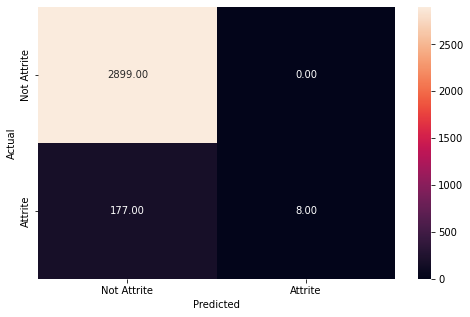

In [ ]:
# Define XGBoost model
xgb_model = XGBClassifier(objective='binary:logistic')

# Define parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.001],
    'gamma': [0, 0.1, 0.5],
    'subsample': [0.5, 0.75, 1],
    'colsample_bytree': [0.5, 0.75, 1]
}

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding accuracy score
print("Best hyperparameters: ", grid_search.best_params_)
print("Accuracy score: ", grid_search.best_score_)

# Fit XGBoost model with best hyperparameters
best_xgb_model =XGBClassifier(objective='binary:logistic', **grid_search.best_params_)
best_xgb_model.fit(X_train, y_train)

y_pred_test = best_xgb_model.predict(X_test)

metrics_score(y_test, y_pred_test)




              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2899
           1       0.60      0.05      0.09       185

    accuracy                           0.94      3084
   macro avg       0.77      0.52      0.53      3084
weighted avg       0.92      0.94      0.92      3084



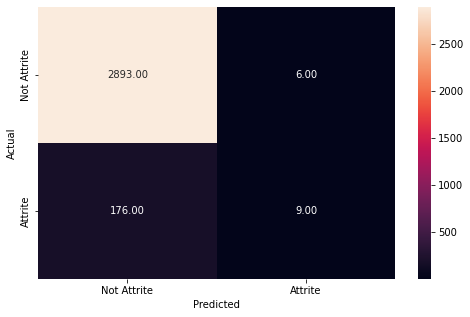

In [ ]:
lgbm_model = LGBMClassifier(objective='binary')
lgbm_model.fit(X_train, y_train)
# Predict on test set and evaluate performance
# Predict the labels of the test set
y_pred_test = lgbm_model.predict(X_test)

metrics_score(y_test, y_pred_test)

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2899
           1       1.00      0.04      0.08       185

    accuracy                           0.94      3084
   macro avg       0.97      0.52      0.53      3084
weighted avg       0.95      0.94      0.92      3084



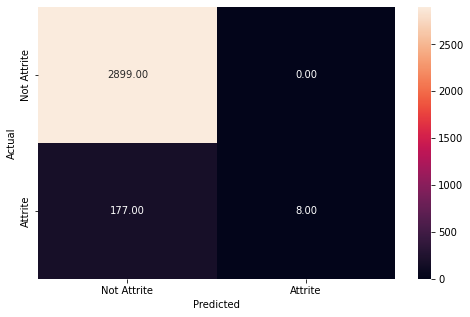

In [ ]:


# Define the hyperparameter grid to search over
param_grid = {
    'num_leaves': [10, 20, 30],
    'learning_rate': [0.1, 0.05, 0.01],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200],
}

# Initialize the LGBMClassifier object
lgbm_model = LGBMClassifier(objective='binary')

# Initialize the GridSearchCV object with 5-fold cross-validation
grid_search = GridSearchCV(estimator=lgbm_model, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)


# Initialize a new LGBMClassifier object with the best hyperparameters
best_lgbm_model = LGBMClassifier(**grid_search.best_params_, objective='binary')

# Train the model on the full training set
best_lgbm_model.fit(X_train, y_train)

# Predict the labels of the test set
y_pred_test = best_lgbm_model.predict(X_test)

metrics_score(y_test, y_pred_test)


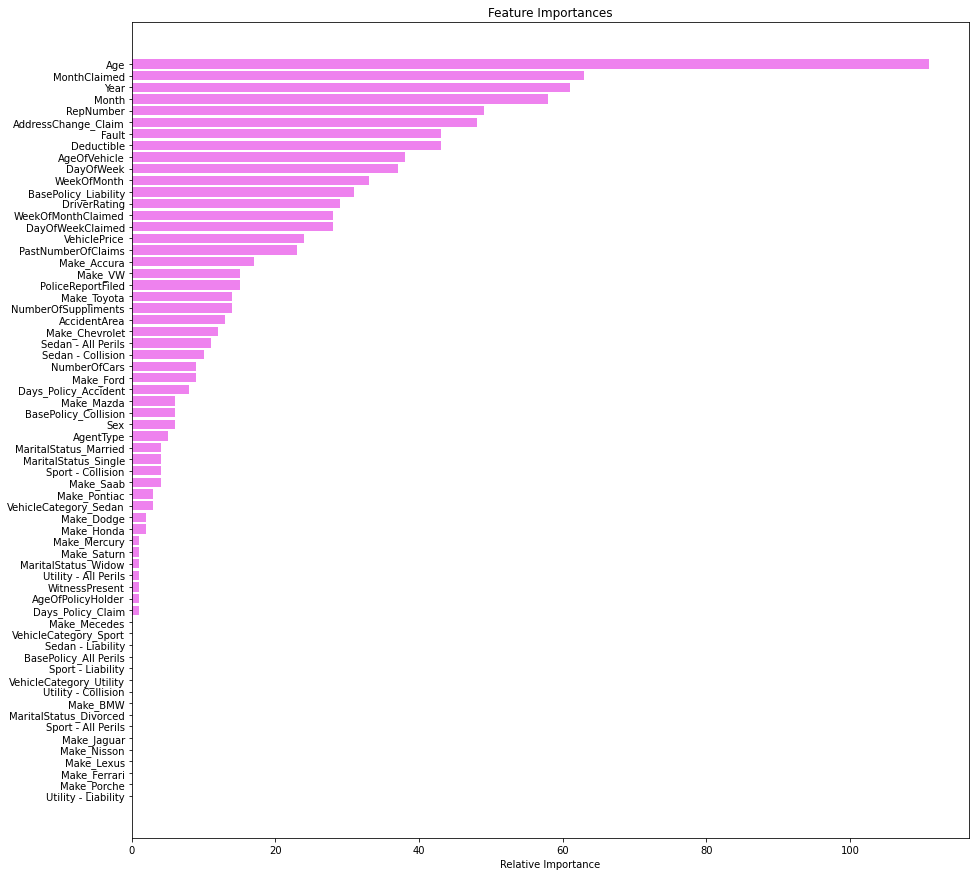

In [ ]:
import numpy as np
feature_names = list(X_train.columns)
importances = best_lgbm_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(15, 15))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()
     